In [2]:
import numpy as np
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
# 读取CSV文件
def load_data(filepath):
    """
    读取包含全年小时数据的CSV文件
    返回: DataFrame(日期时间, 各特征列)
    """
    # 假设CSV文件包含日期时间和各特征列
    df = pd.read_csv(filepath)
    
    # 确保有日期时间列(如果没有则创建)
    if 'datetime' not in df.columns:
        # 假设数据是按小时顺序排列的全年数据
        start_date = datetime(2023, 1, 1)  # 根据实际情况调整
        df['datetime'] = [start_date + timedelta(hours=i) for i in range(len(df))]
    
    # 将datetime列转换为datetime对象(如果尚未转换)
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    return df

# 使用示例
filepath = 'feature.csv'  # 替换为实际文件路径
data = load_data(filepath)
print(data.head())

   order   pv        wt    load            datetime
0      0  0.0  0.874944  4.3344 2023-01-01 00:00:00
1      1  0.0  0.876171  6.5016 2023-01-01 01:00:00
2      2  0.0  0.761241  7.5852 2023-01-01 02:00:00
3      3  0.0  0.582960  8.6688 2023-01-01 03:00:00
4      4  0.0  0.824549  8.6688 2023-01-01 04:00:00


In [3]:
def preprocess_daily_data(df, feature_columns):
    """
    将小时数据按天重组为三维数组(天, 小时, 特征)
    参数:
        df: 原始DataFrame
        feature_columns: 要使用的特征列名列表(如['wind', 'solar', 'load'])
    返回:
        X: 三维数组(天, 24小时, 特征)
        dates: 对应的日期列表
    """
    # 提取日期部分(去掉具体时间)
    df['date'] = df['datetime'].dt.date
    
    # 按天分组
    daily_groups = df.groupby('date')
    
    # 初始化三维数组
    n_days = len(daily_groups)
    n_hours = 24
    n_features = len(feature_columns)
    X = np.zeros((n_days, n_hours, n_features))
    dates = []
    
    # 填充数组
    for i, (date, group) in enumerate(daily_groups):
        # 确保每天有24小时数据(如有缺失需要处理)
        if len(group) == 24:
            X[i] = group[feature_columns].values
            dates.append(date)
        else:
            print(f"警告: 日期 {date} 数据不完整(只有 {len(group)} 小时数据)")
    
    # 标准化数据(对每个特征分别标准化)
    scaler = TimeSeriesScalerMeanVariance()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, dates

# 选择要使用的特征列
feature_cols = ['pv','wt','load']  # 根据实际列名调整

# 预处理数据
X, dates = preprocess_daily_data(data, feature_cols)
print(f"数据形状: {X.shape} (天数, 小时, 特征)")

数据形状: (364, 24, 3) (天数, 小时, 特征)


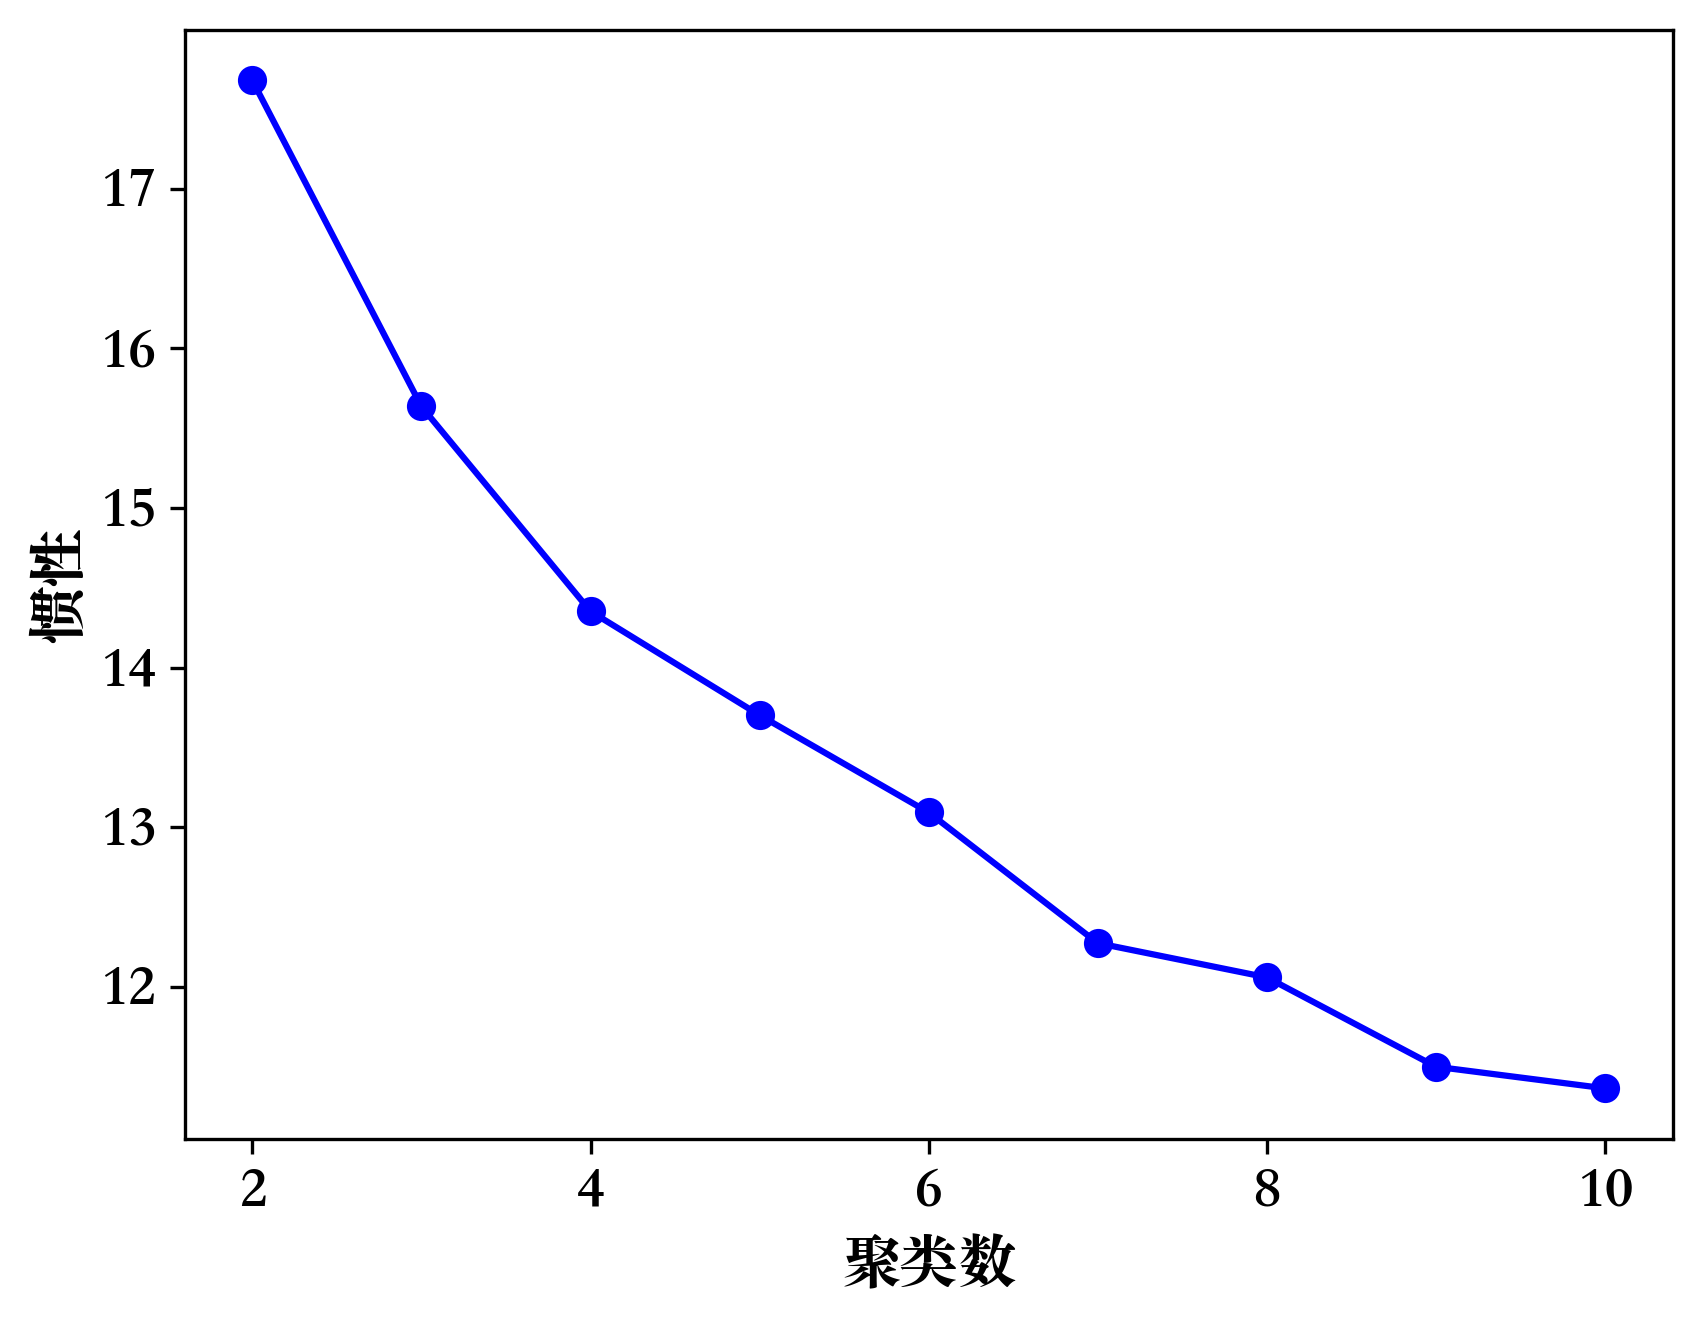

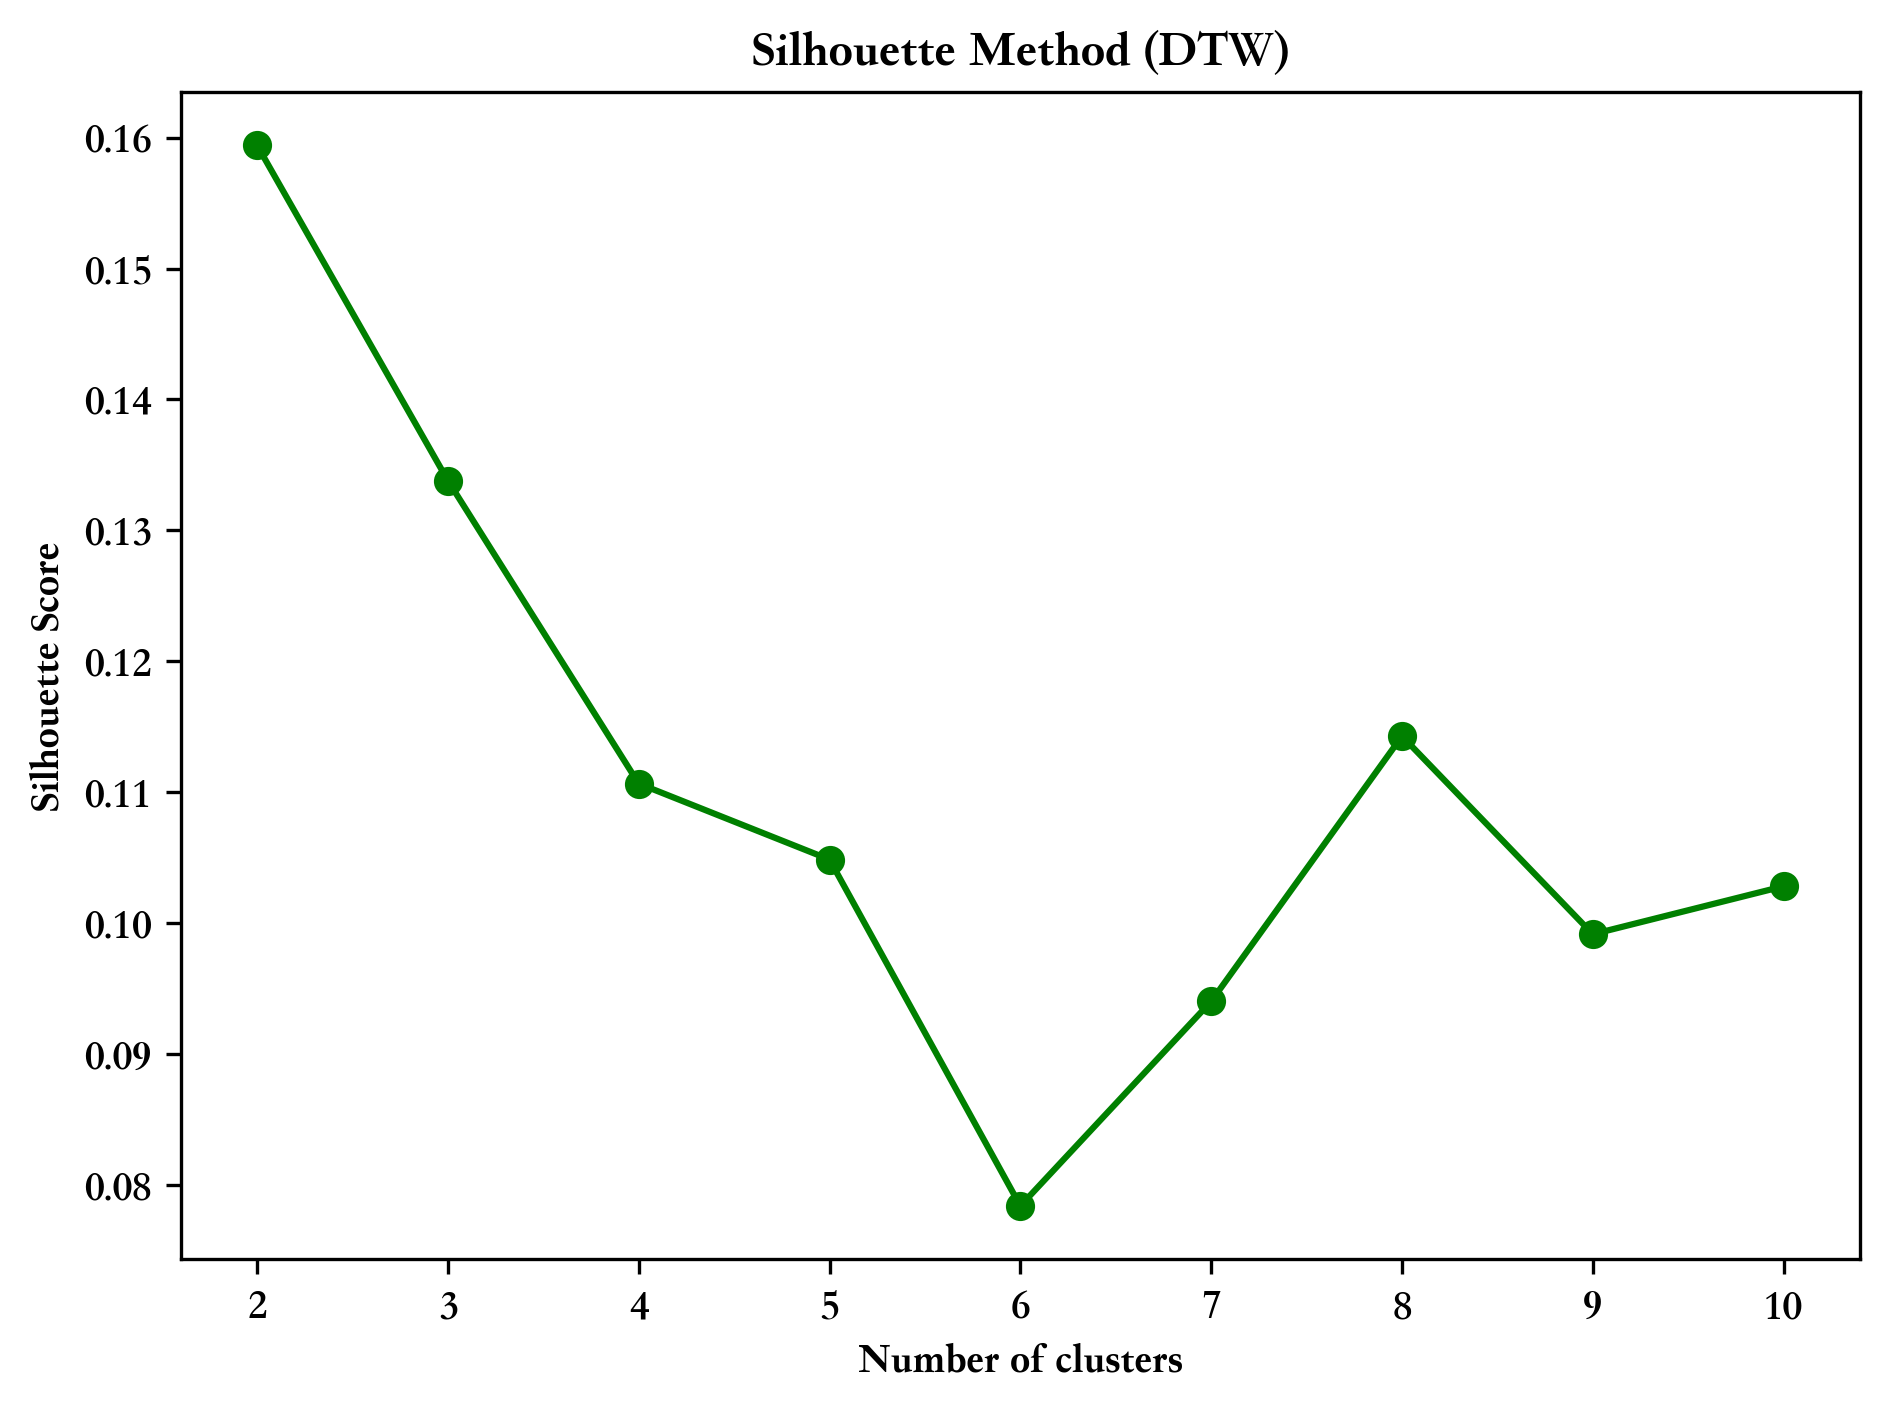

自动确定的最佳聚类数: 9


In [4]:
def find_optimal_dtw_clusters(X, max_k=10):
    """
    使用DTW距离自动确定最佳聚类数
    返回: (最佳聚类数, 所有K的轮廓系数, 所有K的惯性)
    """
    silhouette_scores = []
    inertias = []
    k_values = range(2, max_k+1)
    
    for k in k_values:
        # 使用DTW距离的K-means
        dtw_kmeans = TimeSeriesKMeans(n_clusters=k, 
                                     metric="dtw",
                                     max_iter=10,
                                     random_state=42,
                                     n_init=3)  # 减少计算时间
        
        labels = dtw_kmeans.fit_predict(X)
        
        # 计算轮廓系数
        if len(np.unique(labels)) > 1:
            # 由于DTW距离计算成本高，使用近似方法计算轮廓系数
            silhouette = silhouette_score(X.reshape(X.shape[0], -1), labels)
        else:
            silhouette = -1
            
        silhouette_scores.append(silhouette)
        inertias.append(dtw_kmeans.inertia_)
    
    # 找到轮廓系数最大的K(排除边界值)
    valid_scores = [s if s != -1 else -np.inf for s in silhouette_scores]
    best_k_silhouette = np.argmax(valid_scores) + 2  # +2因为从k=2开始
    
    # 找到肘部点(惯性下降的拐点)
    diff = np.diff(inertias)
    diff_ratio = diff[:-1] / diff[1:]
    best_k_elbow = np.argmax(diff_ratio) + 3  # +3因为需要至少3点计算diff_ratio
    
    # 综合选择(优先轮廓系数)
    if silhouette_scores[best_k_silhouette-2] > 0.5:  # 如果轮廓系数较高
        best_k = best_k_silhouette
    else:
        best_k = best_k_elbow
    plt.rcParams['font.sans-serif'] = ['Songti SC']  # Linux 常用
    plt.rcParams['axes.unicode_minus'] = False
    # 可视化
    plt.figure(dpi=300)
    
    plt.plot(k_values, inertias, 'bo-')
    plt.xlabel('聚类数',fontsize=14)
    plt.ylabel('惯性',fontsize=14)
    plt.tick_params(labelsize=14)
    
    plt.figure(dpi=300)
    plt.plot(k_values, silhouette_scores, 'go-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method (DTW)')
    
    plt.tight_layout()
    plt.show()
    
    return best_k, silhouette_scores, inertias

# 自动确定最佳聚类数
best_k, silhouette_scores, inertias = find_optimal_dtw_clusters(X)
print(f"自动确定的最佳聚类数: {best_k}")

In [ ]:
from tslearn.metrics import dtw
def dtw_clustering_with_representatives(X, dates, n_clusters):
    """
    使用DTW进行时间序列聚类并提取代表性天数
    返回: (聚类模型, 聚类标签, 代表性天数字典)
    """
    # 使用最佳K值进行最终聚类
    final_model = TimeSeriesKMeans(n_clusters=n_clusters,
                                 metric="dtw",
                                 max_iter=20,
                                 random_state=42,
                                 n_init=5)
    labels = final_model.fit_predict(X)
    
    # 获取代表性天数(每个簇中距离质心最近的1天)
    representatives = {}
    for cluster_id in range(n_clusters):
        # 获取当前簇的所有样本
        cluster_indices = np.where(labels == cluster_id)[0]
        cluster_data = X[cluster_indices]
        
        # 计算每个点到质心的DTW距离
        centroid = final_model.cluster_centers_[cluster_id]
        distances = [dtw(centroid, x) for x in cluster_data]
        
        # 找到距离最近的样本
        closest_idx = cluster_indices[np.argmin(distances)]
        representative_date = dates[closest_idx]
        
        representatives[cluster_id] = representative_date
    
    return final_model, labels, representatives

# 执行聚类并获取代表性天数
final_model, labels, representative_days = dtw_clustering_with_representatives(X, dates, best_k)
np.save('labels.npy',labels)
# 输出结果
print("\n聚类结果统计:")
for cluster_id in range(best_k):
    n_days = np.sum(labels == cluster_id)
    print(f"Cluster {cluster_id}: {n_days} 天 ({n_days/len(labels):.1%})")

print("\n代表性天数:")
for cluster_id, rep_date in representative_days.items():
    print(f"Cluster {cluster_id}: {rep_date.strftime('%Y-%m-%d')}")


聚类结果统计:
Cluster 0: 32 天 (8.8%)
Cluster 1: 38 天 (10.4%)
Cluster 2: 42 天 (11.5%)
Cluster 3: 28 天 (7.7%)
Cluster 4: 68 天 (18.7%)
Cluster 5: 56 天 (15.4%)
Cluster 6: 49 天 (13.5%)
Cluster 7: 26 天 (7.1%)
Cluster 8: 25 天 (6.9%)

代表性天数:
Cluster 0: 2023-09-20
Cluster 1: 2023-12-19
Cluster 2: 2023-02-21
Cluster 3: 2023-05-01
Cluster 4: 2023-12-26
Cluster 5: 2023-12-12
Cluster 6: 2023-04-18
Cluster 7: 2023-03-08
Cluster 8: 2023-02-23


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


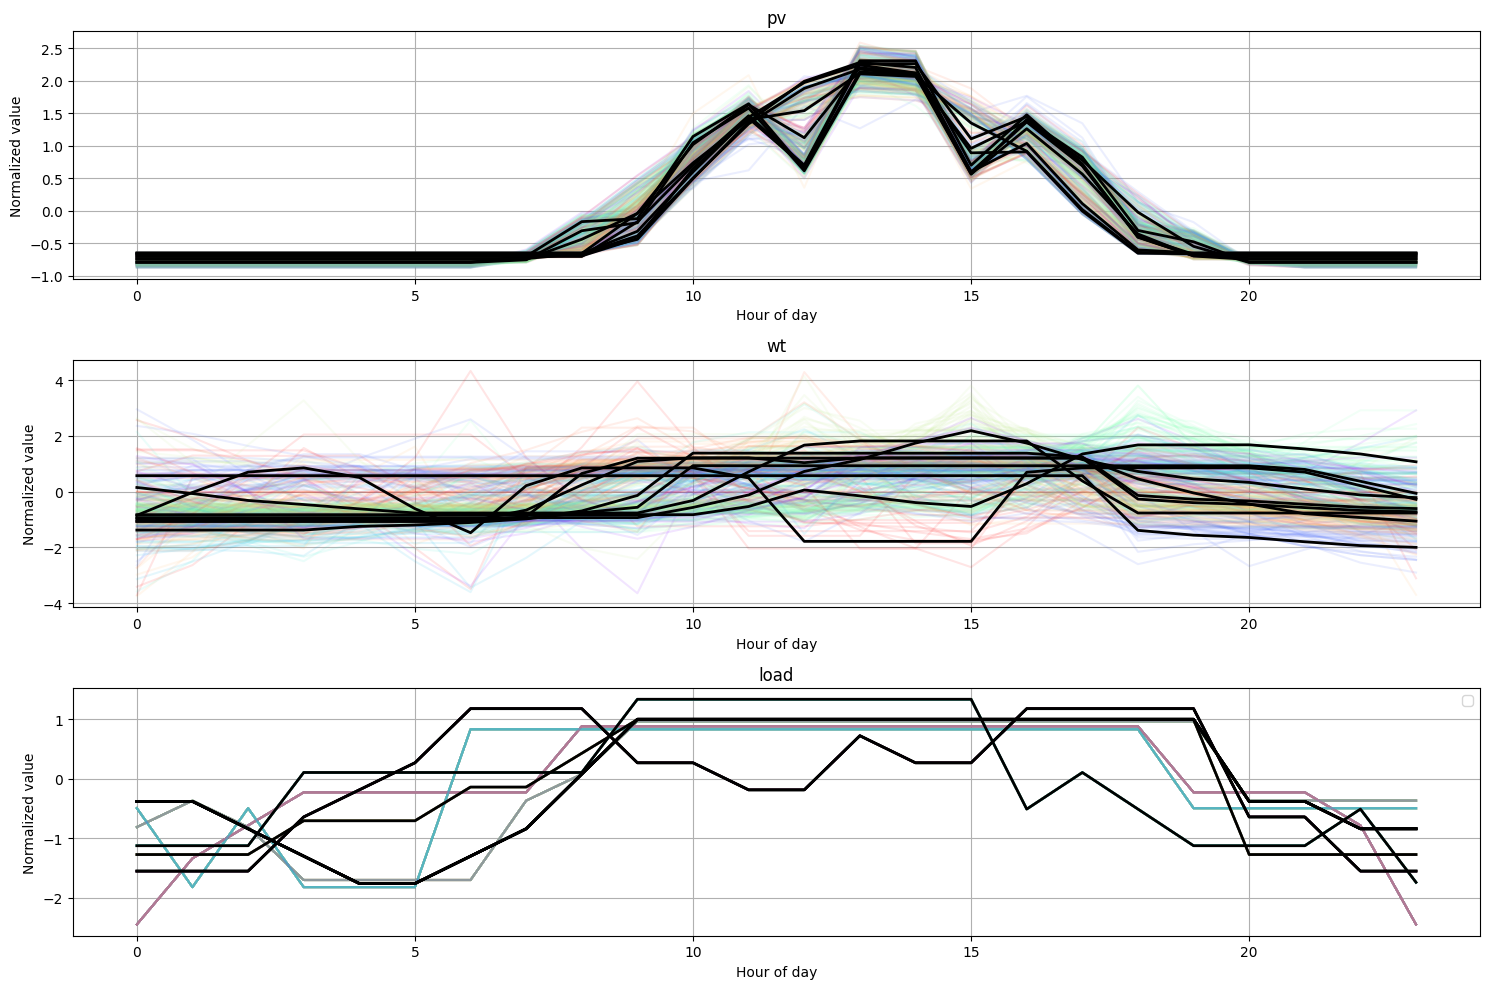

In [13]:
def plot_daily_patterns(X, dates, labels, representative_days, feature_names):
    """
    可视化每天的曲线模式和代表性天数
    """
    plt.figure(figsize=(15, 10))
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    # 为每个特征创建子图
    for feature_idx, feature_name in enumerate(feature_names):
        plt.subplot(len(feature_names), 1, feature_idx+1)
        
        # 绘制所有天的曲线(按聚类着色)
        for day_idx in range(X.shape[0]):
            plt.plot(X[day_idx, :, feature_idx], 
                    color=colors[labels[day_idx]], 
                    alpha=0.1)
        
        # 标记代表性天数
        for cluster_id, rep_date in representative_days.items():
            rep_day_idx = dates.index(rep_date)
            plt.plot(X[rep_day_idx, :, feature_idx],
                    color='black',
                    linewidth=2,
                    label=f'Cluster {cluster_id}' if feature_idx == 0 else None)
        
        plt.title(feature_name)
        plt.xlabel('Hour of day')
        plt.ylabel('Normalized value')
        plt.grid(True)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

# 可视化结果
plot_daily_patterns(X, dates, labels, representative_days, feature_cols)

In [14]:
def organize_representative_days(data, representatives, feature_columns):
    """
    整理代表性天数的数据
    参数:
        data: 原始DataFrame
        representatives: 代表性天数字典 {cluster_id: date}
        feature_columns: 需要保存的特征列名列表
    返回:
        按时间排序的DataFrame，包含代表性天数的所有小时数据
    """
    # 创建空DataFrame存储结果
    result_df = pd.DataFrame()
    
    # 为每个代表性天数提取数据
    for cluster_id, rep_date in representatives.items():
        # 获取当天的所有小时数据
        day_data = data[data['datetime'].dt.date == rep_date].copy()
        
        # 添加聚类标签列
        day_data['cluster'] = cluster_id
        
        # 添加到结果DataFrame
        result_df = pd.concat([result_df, day_data])
    
    # 按时间排序
    result_df = result_df.sort_values('datetime')
    
    # 选择需要保存的列
    columns_to_save = ['datetime', 'cluster'] + feature_columns
    result_df = result_df[columns_to_save]
    
    return result_df
def save_representative_days_to_csv(representative_data, output_file):
    """
    将代表性天数数据保存到CSV文件
    参数:
        representative_data: 整理好的代表性天数DataFrame
        output_file: 输出文件路径
    """
    # 确保datetime列格式正确
    representative_data['datetime'] = representative_data['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
    # 保存到CSV
    representative_data.to_csv(output_file, index=False)
    print(f"代表性天数数据已保存到: {output_file}")
representative_data = organize_representative_days(data, representative_days, feature_cols)
save_representative_days_to_csv(representative_data, 'output.csv')

代表性天数数据已保存到: output.csv



=== t-SNE可视化 ===


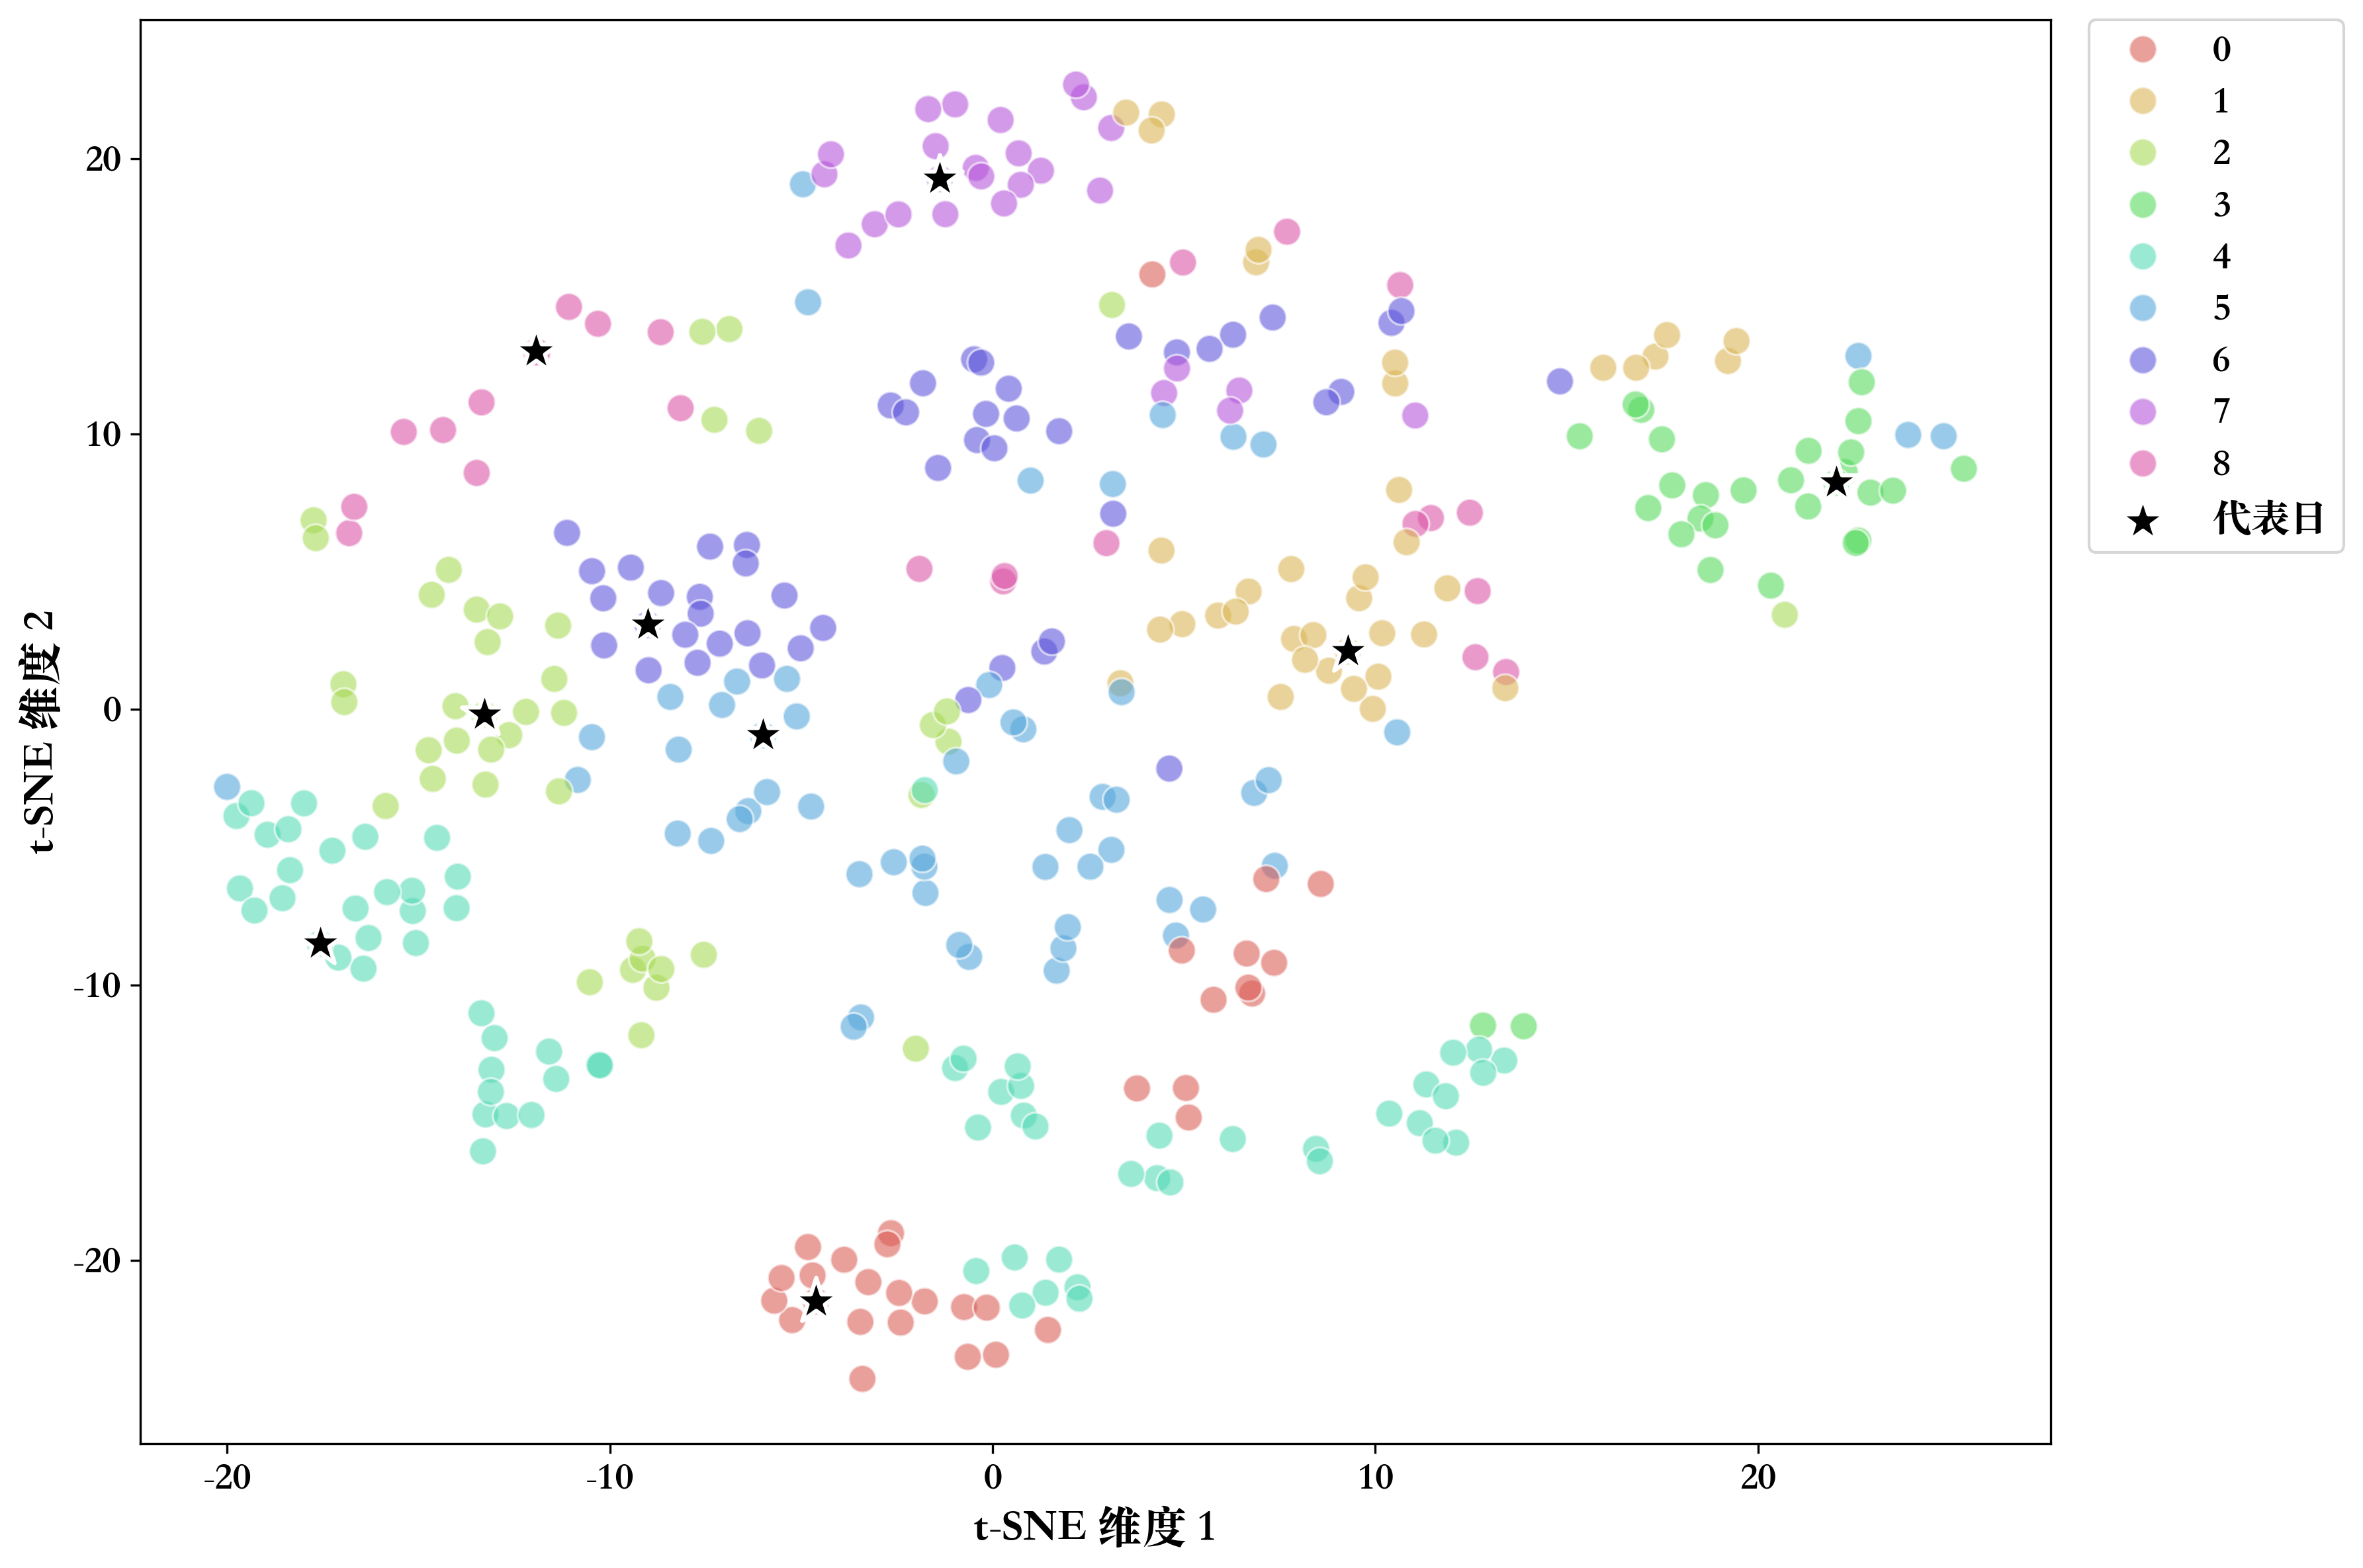

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_with_tsne(features, labels, representative_indices=None, perplexity=30, random_state=42):
    """
    使用t-SNE可视化聚类结果
    参数:
        features: 原始特征数据(2D数组: n_samples × n_features)
        labels: 聚类标签数组
        representative_indices: 代表性样本的索引(可选)
        perplexity: t-SNE的困惑度参数
        random_state: 随机种子
    """
    # 执行t-SNE降维
    tsne = TSNE(n_components=2, 
                perplexity=perplexity,
                random_state=random_state,
                n_iter=1000)
    tsne_results = tsne.fit_transform(features)
    
    # 创建DataFrame便于绘图
    tsne_df = pd.DataFrame({
        'tsne_1': tsne_results[:, 0],
        'tsne_2': tsne_results[:, 1],
        'cluster': labels
    })
    plt.rcParams['font.sans-serif'] = ['Songti SC']  # Linux 常用
    plt.rcParams['axes.unicode_minus'] = False
    # 绘制聚类结果
    plt.figure(figsize=(12, 8),dpi=300)
    scatter = sns.scatterplot(
        x='tsne_1', y='tsne_2',
        hue='cluster',
        palette=sns.color_palette("hls", len(np.unique(labels))),
        data=tsne_df,
        alpha=0.6,
        s=100,
        legend="full"
    )
    
    # 标记代表性样本(如果提供)
    if representative_indices is not None:
        rep_points = tsne_df.iloc[representative_indices]
        plt.scatter(
            x=rep_points['tsne_1'],
            y=rep_points['tsne_2'],
            c='black',
            marker='*',
            s=300,
            edgecolor='w',
            linewidth=1.5,
            label='代表日'
        )
    
    plt.xlabel('t-SNE 维度 1',fontsize=16)
    plt.ylabel('t-SNE 维度 2',fontsize=16)
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2,fontsize=14,borderaxespad=0.)
    plt.tick_params(labelsize=14)
    plt.tight_layout()
    plt.show()
    
    return tsne_df
def prepare_features_for_tsne(X, labels, representatives, dates):
    """
    准备用于t-SNE的特征数据
    参数:
        X: 原始3D时间序列数据(天数×小时×特征)
        labels: 聚类标签
        representatives: 代表性天数字典 {cluster_id: date}
        dates: 日期列表
    返回:
        features_2d: 2D特征数组(天数×特征)
        representative_indices: 代表性样本的索引
    """
    # 将3D时间序列展平为2D (天数 × (小时×特征))
    features_2d = X.reshape(X.shape[0], -1)
    
    # 获取代表性样本的索引
    representative_indices = []
    for rep_date in representatives.values():
        idx = dates.index(rep_date)
        representative_indices.append(idx)
    
    return features_2d, representative_indices
features_2d, rep_indices = prepare_features_for_tsne(X, labels, representative_days, dates)
print("\n=== t-SNE可视化 ===")
tsne_df = visualize_with_tsne(features_2d, labels, rep_indices)